In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import CoraFull, Planetoid, CitationFull
import torch_geometric.nn as gnn 
import torch_geometric.transforms as T

from adamp import AdamP

#from models import GPS
#from utils import test_model

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

/home/sujin/anaconda3/envs/ds503/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=3)

In [2]:
transform = T.Compose([T.NormalizeFeatures(), T.AddRandomWalkPE(12, 'RWPE')])
dataset = CitationFull(root='dataset/Cora', name='Cora', transform=transform)

In [3]:
#torch.save(dataset, "/home/sujin/project/DS503/ds503/dataset/Cora/cora/RandomWalkPE.pt")
#dataset = torch.load("/home/sujin/project/DS503/ds503/dataset/Cora/cora/RandomWalkPE.pt")

In [4]:
'''
data = dataset[0]
df = pd.DataFrame(data.x.cpu())
df['y'] = data.y.cpu()
train, valid = train_test_split(df, stratify=df.y, test_size=0.33)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train.index]=True
data = data.to(device)
'''

"\ndata = dataset[0]\ndf = pd.DataFrame(data.x.cpu())\ndf['y'] = data.y.cpu()\ntrain, valid = train_test_split(df, stratify=df.y, test_size=0.33)\ndata.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)\ndata.train_mask[train.index]=True\ndata = data.to(device)\n"

In [5]:
#torch.save(data.cpu(), "/home/sujin/sujin/ds503/dataset/RandomWalkPE.pt")

In [6]:
data = torch.load("/home/sujin/sujin/ds503/dataset/RandomWalkPE.pt")
data = data.to(device)

# GIN backbone

In [7]:
import random
import numpy as np

import torch
import torch.nn as nn

import torch_geometric.nn as gnn 

import torch
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential
from torch_geometric.nn.conv import TransformerConv, GPSConv

class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = None

    def get_n_params(self):
        pp=0
        for p in list(self.model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp
    
    def build_model(self):
        raise NotImplementedError

class GraphSAGE(GNN):
    def __init__(self, in_channels, hidden_channels, number_of_classes, num_of_hidden_layers, device, heads=8):
        super().__init__()
        torch.manual_seed(42)
        self.num_of_hidden_layers = num_of_hidden_layers
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.number_of_classes = number_of_classes
        self.device = device
        self.heads = heads
        self.model = self.build_model()
        self.num_of_parameters = self.get_n_params()

    def forward(self, x, edge_index):
        return self.model(x, edge_index)
    
    def build_model(self):
        layers=[]
        for i in range(self.num_of_hidden_layers):
            layers.append((nn.Dropout(0.5), 'x -> x'))
            layers.append((gnn.TransformerConv(in_channels=self.in_channels if i==0 else self.hidden_channels,
                                  out_channels=self.hidden_channels),'x, edge_index -> x'))
            layers.append(nn.ELU(inplace=True))
        layers.append(nn.Linear(in_features=self.hidden_channels, out_features=self.number_of_classes))
        return gnn.Sequential('x, edge_index', layers)

# Train

In [8]:
model = GraphSAGE(in_channels = data.x.shape[1],\
             hidden_channels=128,\
                  number_of_classes = len(data.y.unique()),\
                        num_of_hidden_layers = 3,\
                        device = device,
                          heads=2)
print(model.get_n_params())
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamP(model.parameters(), lr=0.01, weight_decay=5e-4)

4601158


In [9]:
def train_model(model, data:torch_geometric.data.data.Data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()    
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pred = out.argmax(dim=-1)
    correct = pred[data.train_mask] == data.y[data.train_mask]
    acc = int(correct.sum()) / int(data.train_mask.sum())
    return loss.detach().cpu().numpy(), acc

In [10]:
losses = []
accs = []
data = data.to(device)
for epoch in range(500):
    loss, acc = train_model(model, data, optimizer, criterion)
    losses.append(loss.item())
    accs.append(100*acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {100*acc:.2f}')

Epoch: 000, Loss: 4.2458, Acc: 1.33
Epoch: 001, Loss: 4.1202, Acc: 4.72
Epoch: 002, Loss: 4.0960, Acc: 4.79
Epoch: 003, Loss: 4.0007, Acc: 5.87
Epoch: 004, Loss: 4.0064, Acc: 8.08
Epoch: 005, Loss: 3.9688, Acc: 8.57
Epoch: 006, Loss: 3.9182, Acc: 8.65
Epoch: 007, Loss: 3.8143, Acc: 9.14
Epoch: 008, Loss: 3.6595, Acc: 14.52
Epoch: 009, Loss: 3.4243, Acc: 15.69
Epoch: 010, Loss: 3.1732, Acc: 20.81
Epoch: 011, Loss: 2.9723, Acc: 21.38
Epoch: 012, Loss: 2.8057, Acc: 30.68
Epoch: 013, Loss: 2.7572, Acc: 27.30
Epoch: 014, Loss: 2.4946, Acc: 33.01
Epoch: 015, Loss: 2.3988, Acc: 35.64
Epoch: 016, Loss: 2.1997, Acc: 41.75
Epoch: 017, Loss: 2.1197, Acc: 42.32
Epoch: 018, Loss: 1.9909, Acc: 45.82
Epoch: 019, Loss: 1.8831, Acc: 49.75
Epoch: 020, Loss: 1.8269, Acc: 51.74
Epoch: 021, Loss: 1.7752, Acc: 52.52
Epoch: 022, Loss: 1.6868, Acc: 53.94
Epoch: 023, Loss: 1.6255, Acc: 55.45
Epoch: 024, Loss: 1.5709, Acc: 57.27
Epoch: 025, Loss: 1.5306, Acc: 58.47
Epoch: 026, Loss: 1.4823, Acc: 59.75
Epoch: 02

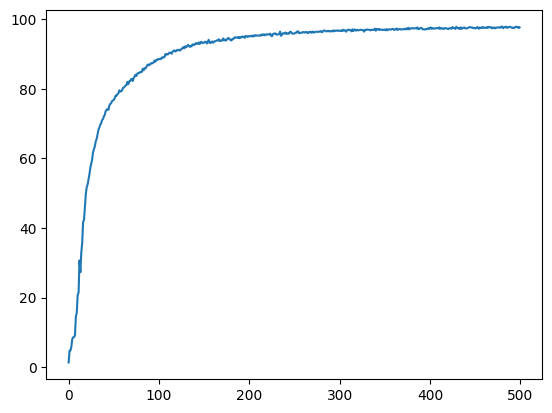

In [11]:
plt.plot(accs)

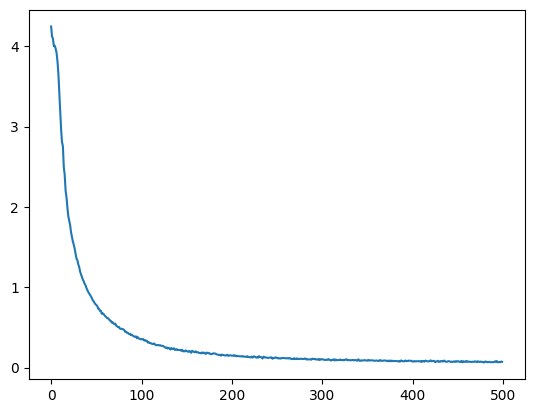

In [12]:
plt.plot(losses)

In [13]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=-1)
correct = (pred[~data.train_mask] == data.y[~data.train_mask])
acc = int(correct.sum()) / int(correct.shape[0])
f1 = f1_score(data.y[~data.train_mask.cpu()].cpu(), pred[~data.train_mask.cpu()].cpu(), average='micro')
report = pd.DataFrame(classification_report(data.y[~data.train_mask.cpu()].cpu(), pred[~data.train_mask.cpu()].cpu(), output_dict=True)).T

In [14]:
result_sliced = report.iloc[:-3 if len(report) < 23 else 20, :]
acc = report.loc['accuracy'][0]
report.loc['minorities-f1',:] = result_sliced.mean(axis=0)
print(f'Test Acc: {100*acc}')

Test Acc: 69.62645437844458


In [15]:
#GraphSAGE_layers4_neurons256
report.to_csv("/home/sujin/sujin/ds503/results/Transformer_layers3_neurons128.csv")

In [16]:
train_res_loss = pd.DataFrame({'Transformer_layers3_neurons128' : losses})
train_res_loss.to_csv('./results/train_results/Transformer_layers3_neurons128.csv', index=False)

In [17]:
train_res_acc = pd.DataFrame({'Transformer_layers3_neurons128' : accs})
train_res_acc.to_csv('./results/train_results/Transformer_layers3_neurons128.csv', index=False)